Hello, I hope you're doing great. Welcome to the analysis and interpretation of a public Vancouver dataset, that includes business license records from 2024 onwards. In this notebook, we will walk through the process needed to create some sort of conclusion for the plausibility of starting a certain type of business in a certain location in Vancouver. We need to start by importing some libraries that will make our analysis simpler: 

In [1]:
import pandas as pd

import seaborn as sns

from pandas._libs.tslibs.offsets import BusinessMixin

import matplotlib.pyplot as plt

import numpy as np

In [2]:
# Let's read this csv data file into a dataframe:

df = pd.read_csv("business-licences.csv", sep=";", low_memory = False)

# Let's look at some general info about the dataframe:

print(df.shape)

(131740, 25)


In [3]:
# Let's look at the variables:

print(df.columns)

Index(['FOLDERYEAR', 'LicenceRSN', 'LicenceNumber', 'LicenceRevisionNumber',
       'BusinessName', 'BusinessTradeName', 'Status', 'IssuedDate',
       'ExpiredDate', 'BusinessType', 'BusinessSubType', 'Unit', 'UnitType',
       'House', 'Street', 'City', 'Province', 'Country', 'PostalCode',
       'LocalArea', 'NumberofEmployees', 'FeePaid', 'ExtractDate', 'Geom',
       'geo_point_2d'],
      dtype='object')


In [4]:
# We can start thinking about which ones we want to use later. 
# For now, let's make sure that we view all columns when we print the dataframe:

pd.set_option('display.max_columns', None)

# We can look at some example data:

print(df.head(n = 3))

   FOLDERYEAR  LicenceRSN LicenceNumber  LicenceRevisionNumber  \
0          24     4491140     24-108817                     10   
1          24     4491148     24-108826                     10   
2          24     4491150     24-108829                     10   

                    BusinessName BusinessTradeName  Status  \
0             Imperva Canada ULC               NaN  Issued   
1  SuperNatural Game Studios Inc               NaN  Issued   
2               Ansys Canada Ltd               NaN  Issued   

                  IssuedDate ExpiredDate  \
0  2023-12-19T11:37:18-08:00  2024-12-31   
1  2023-11-21T11:38:56-08:00  2024-12-31   
2  2024-03-01T13:13:58-08:00  2024-12-31   

                           BusinessType BusinessSubType  Unit UnitType House  \
0  Information Communication Technology             NaN   410     Unit   700   
1  Information Communication Technology             NaN   400     Unit    56   
2  Information Communication Technology             NaN  1700     Uni

In [5]:
# This helps us understand the data better, like for example, there are specific coordinates for many business licenses, but not all.
# Let's now look at the data types of each variable:

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131740 entries, 0 to 131739
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   FOLDERYEAR             131740 non-null  int64  
 1   LicenceRSN             131740 non-null  int64  
 2   LicenceNumber          131740 non-null  object 
 3   LicenceRevisionNumber  131740 non-null  int64  
 4   BusinessName           123071 non-null  object 
 5   BusinessTradeName      49803 non-null   object 
 6   Status                 131740 non-null  object 
 7   IssuedDate             114921 non-null  object 
 8   ExpiredDate            114939 non-null  object 
 9   BusinessType           131740 non-null  object 
 10  BusinessSubType        13744 non-null   object 
 11  Unit                   31581 non-null   object 
 12  UnitType               31412 non-null   object 
 13  House                  71613 non-null   object 
 14  Street                 71625 non-nul

In [6]:
# I want to know more about geom and geo_point_2d. let's generate a sample of what it looks like:
#print(df['Geom'].sample(10))

# one of the samples: {"coordinates": [-123.121381503733, 49.2635970...

# That looks hard to manipulate. Maybe we can use geo_point_2d instead.

print(df['geo_point_2d'].sample(10)) 

90360                                     NaN
29557                                     NaN
79174      49.226679782002, -123.090324931247
118128    49.2837724104188, -123.114768826392
57154      49.278968908765, -123.101335160541
16779     49.2766687622173, -123.121680334857
58998                                     NaN
92468                                     NaN
45541                                     NaN
85729                                     NaN
Name: geo_point_2d, dtype: object


In [7]:
# This looks easier to use. We can maybe use this to plot coordinates later.
# Let's look at the number of null values for each variable:

print(df.isnull().sum())

FOLDERYEAR                    0
LicenceRSN                    0
LicenceNumber                 0
LicenceRevisionNumber         0
BusinessName               8669
BusinessTradeName         81937
Status                        0
IssuedDate                16819
ExpiredDate               16801
BusinessType                  0
BusinessSubType          117996
Unit                     100159
UnitType                 100328
House                     60127
Street                    60115
City                         35
Province                     48
Country                   25514
PostalCode                60628
LocalArea                  2717
NumberofEmployees             0
FeePaid                   64390
ExtractDate                   0
Geom                      65252
geo_point_2d              65252
dtype: int64


In [8]:
# It looks like geographical data is missing for 65252 observations. That'll be important when cleaning this data.
# Let's look at the unique values for business type:

print(df['BusinessType'].value_counts())

BusinessType
Long-term Rental                          29425
Health Care Professionals and Services    11547
General Contractor                        10128
Short-term Rental Operator                 8629
Retail Dealer                              6181
                                          ...  
Urban Farm Class A                            6
Marine Service Station                        4
Adult Services                                3
Amusement Park                                2
Oil Gas and Other Fuels                       2
Name: count, Length: 95, dtype: int64


In [9]:
# There are a lot of different business types, but some of them have very little values, 
# which we may need to drop later for reliable results.
# Let's now see the different values for status, and the distribution of status

print(df['Status'].value_counts())

Status
Issued                  109119
Pending                  11005
Gone Out of Business      4811
Inactive                  4112
Cancelled                 2693
Name: count, dtype: int64


In [10]:
# We can also look at the different counts for different local areas, to check variety.

print(df['LocalArea'].value_counts())

print(df['LocalArea'].nunique())

LocalArea
Downtown                    31389
Fairview                    10430
Kitsilano                    8511
Mount Pleasant               8259
Out of Town                  7823
West End                     6945
Kensington-Cedar Cottage     6735
Grandview-Woodland           5605
Renfrew-Collingwood          5415
Sunset                       4790
Marpole                      4475
Hastings-Sunrise             4295
Riley Park                   4177
Strathcona                   4157
Victoria-Fraserview          2677
Killarney                    2326
Dunbar-Southlands            2245
Arbutus-Ridge                1758
Kerrisdale                   1717
West Point Grey              1659
South Cambie                 1380
Oakridge                     1318
Shaughnessy                   898
UBC                            27
Arbutus Ridge                  12
Name: count, dtype: int64
25


There is a great variety in areas, but we can see that Arbutus Ridge and UBC, with just 12 and 27 observations respectfully, might not provide meaningful results when we are making predictions based off of market data. This means we might want to drop them to make our overall conclusions stronger. However, Arbutus Ridge is interesting, because we see that there is another Arbutus Ridge above, named Arbutus-Ridge with a dash. That one has a substantially greater amount of values. This is likely just a formatting issue, so we can combine the registrations of Arbutus-Ridge and Arbutus Ridge into just, Arbutus-Ridge. After, we can create a new dataset that doesn't include UBC, as there are simply not enough registrations to make meaningful inferences on it. 

In [11]:
# Let's start by merging Arbutus-Ridge values with Arbutus Ridge:

df1 = df.copy()

df1['LocalArea'] = df1['LocalArea'].replace({'Arbutus Ridge': 'Arbutus-Ridge'})

# Let's now drop UBC for insufficient data:

df1 = df1[df1['LocalArea'] != 'UBC'].copy()

# Now let's just check counts to confirm the merge and removal worked properly:

print(df1['LocalArea'].value_counts())

print(df1['LocalArea'].unique())


LocalArea
Downtown                    31389
Fairview                    10430
Kitsilano                    8511
Mount Pleasant               8259
Out of Town                  7823
West End                     6945
Kensington-Cedar Cottage     6735
Grandview-Woodland           5605
Renfrew-Collingwood          5415
Sunset                       4790
Marpole                      4475
Hastings-Sunrise             4295
Riley Park                   4177
Strathcona                   4157
Victoria-Fraserview          2677
Killarney                    2326
Dunbar-Southlands            2245
Arbutus-Ridge                1770
Kerrisdale                   1717
West Point Grey              1659
South Cambie                 1380
Oakridge                     1318
Shaughnessy                   898
Name: count, dtype: int64
['Downtown' 'Mount Pleasant' 'Arbutus-Ridge' 'Marpole' 'West End'
 'Strathcona' 'Kitsilano' 'Grandview-Woodland' 'South Cambie'
 'Hastings-Sunrise' 'Fairview' 'Kensington-Cedar Cotta

In [12]:
# Nice! Now let's keep checking that our data doesn't have anything funky.                                            
# Let's drop observations with a null geo_point_2d value:

df1 = df1[df1['geo_point_2d'].notnull()].copy()

In [13]:
# Now let's check if there are any duplicate values:

print(df1.duplicated().sum())

0


In [14]:
# We can now try creating a visual representation of the data, using geo_point_2d.
# We do have a slight problem though, if we want to graph based on two axises, we need to split the column into two.
# Let's do just that:

df1[['lat', 'long']] = df1['geo_point_2d'].str.split(',', expand = True)

print(df1['lat'].sample(2))

print(df1['long'].sample(2))

935       49.2859564086973
122853    49.2806092828486
Name: lat, dtype: object
96843     -123.051011605856
766       -123.111888756655
Name: long, dtype: object


In [15]:
# Great, we now have separate columns for latitude and longitude. 
# They are still strings though, so we need to convert them to floats.

df1[['lat', 'long']] = df1[['lat', 'long']].astype(float)


['Downtown' 'Mount Pleasant' 'Arbutus-Ridge' 'Marpole' 'Strathcona'
 'Grandview-Woodland' 'Fairview' 'Kensington-Cedar Cottage' 'Kitsilano'
 'Hastings-Sunrise' 'Dunbar-Southlands' 'Sunset' 'West End' 'Kerrisdale'
 'Riley Park' 'Renfrew-Collingwood' 'West Point Grey'
 'Victoria-Fraserview' 'Shaughnessy' 'Killarney' 'Oakridge' 'South Cambie'
 'Out of Town']


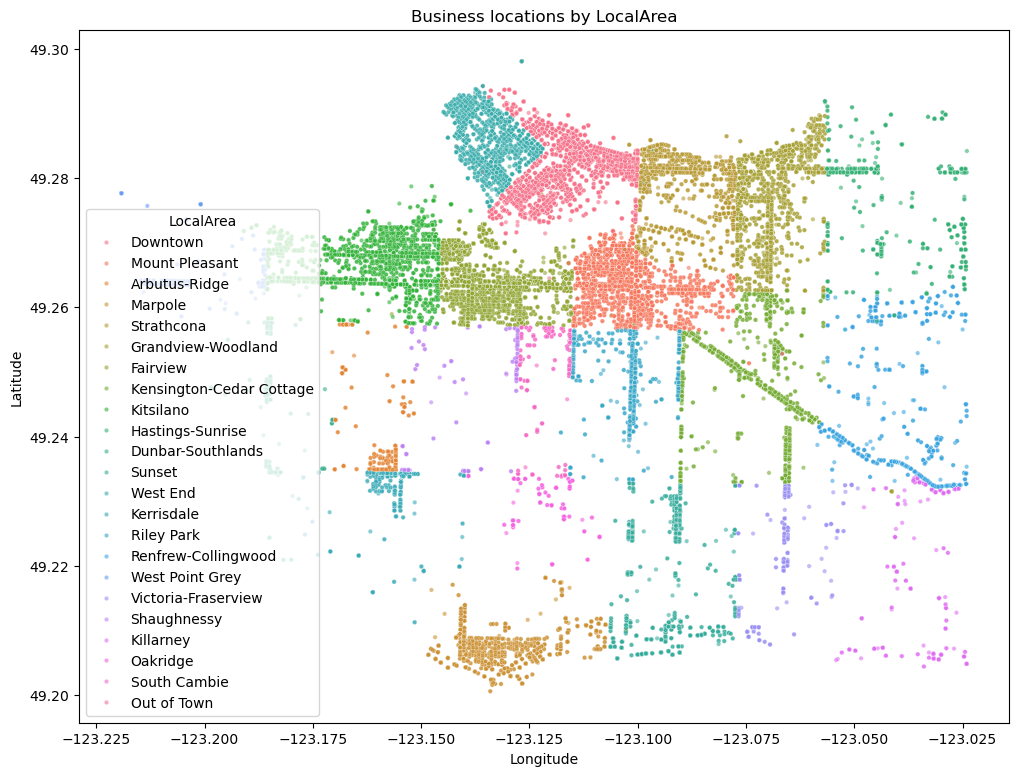

In [16]:
# Great. Now we can make a scatterplot with longitude and latitude, to see where business locations are distributed.

if 'LocalArea' not in df1.columns:
    df1['LocalArea'] = 'Unknown'

unique_local_areas = df1['LocalArea'].unique()

print(unique_local_areas)

plt.figure(figsize=(12, 9))
sns.scatterplot(
    data=df1,
    x='long',
    y='lat',
    hue='LocalArea',
    s=10,
    alpha=0.6)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Business locations by LocalArea')
plt.show()



91


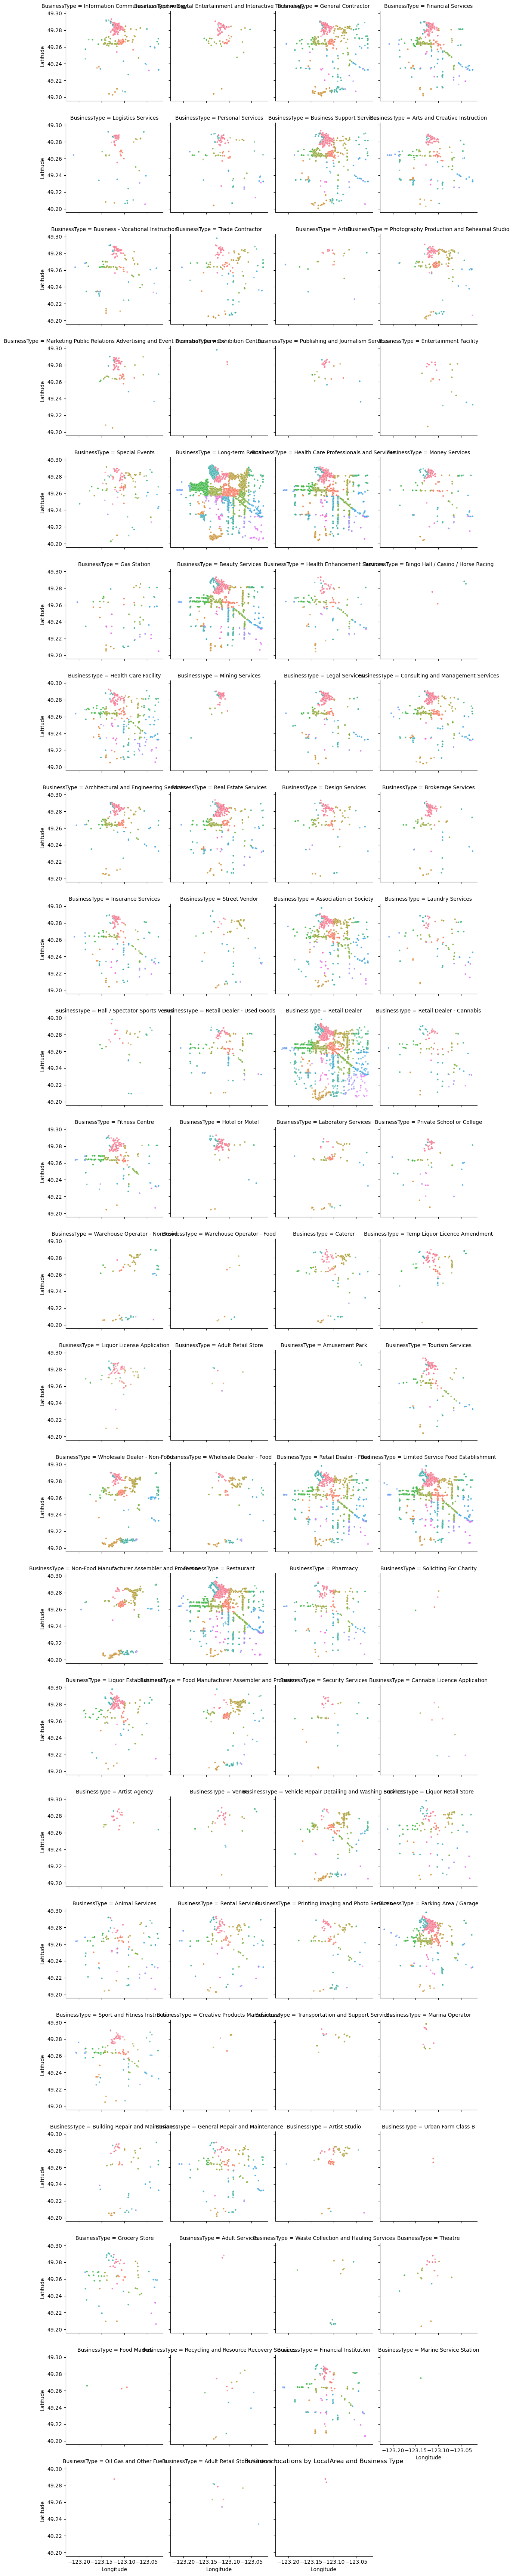

In [17]:
# It looks crowded, so let's use faceting to separate by BusinessType instead:

unique_biz_types = df1['BusinessType'].nunique()

print(unique_biz_types)


g = sns.relplot(
    data=df1,
    x='long',
    y='lat',
    hue= 'LocalArea',
    col='BusinessType',
    col_wrap=4,            # panels per row
    height=3,              # height per facet (inches)
    aspect=1,              # width = height * aspect
    kind='scatter',
    s=10,
    alpha=0.6,
    facet_kws={'sharex': True, 'sharey': True},
    legend = False
)

g.set_axis_labels("Longitude", "Latitude")
plt.title('Business locations by LocalArea and Business Type')
plt.show()  


Alright, wow! That's a lot of graphs, and calls for a different way of initial analysis methods. We will come back to looking at graphs, but for now, we can just note that some business types seem to have a very little number of registrations. 

Anywho, we need to move on by doing some manipulation and interpretation on the numbers in the dataset.

Something to realize now is that if we are using spacial data to analyze over/undersaturation,
we shouldn't account for businesses types that are strictly online/are not location dependant.
So, we will filter out registrations of the following business type:

In [18]:
# Alright, wow! That's a lot of graphs, and calls for a different way of initial analysis methods. 
# Something tor realize now is that if we are using spacial data to analyze over/undersaturation,
# we shouldn't account for businesses types that are strictly online/are not location dependant.
# So, we will filter out registrations of the following business type:

drop_types = [
    'Information Communication Technology',
    'Digital Entertainment and Interactive Technology',
    'Publishing and Journalism Services',
    'Marketing Public Relations Advertising and Event Promotion Services',
    'Consulting and Management Services',
    'Business Support Services',
    'Design Services',
    'Architectural and Engineering Services',
    'Legal Services',
    'Insurance Services',
    'Financial Services',
    'Financial Institution',
    'Brokerage Services',
    'Real Estate Services',
    'Artist Agency',
    'Association or Society',
    'Mining Services',
    'Forestry Services',
    'Oil Gas and Other Fuels',
    'Logistics Services',
    'Transportation and Support Services',
    'Warehouse Operator - Food',
    'Warehouse Operator - Non-Food',
    'Wholesale Dealer - Food',
    'Wholesale Dealer - Non-Food',
    'Non-Food Manufacturer Assembler and Processor',
    'Food Manufacturer Assembler and Processor',
    'Recycling and Resource Recovery Services',
    'Waste Collection and Hauling Services',
    'Marine Service Station',
    'Soliciting For Charity',
    'Cannabis Licence Application',
    'Liquor License Application',
    'Temp Liquor Licence Amendment',
    'Adult Retail Store *Historic*'
]

df_filtered_0 = df1[~df1['BusinessType'].isin(drop_types)].copy()

print(df_filtered_0['BusinessType'].nunique())


56


In [19]:
# Now, we are only considering businesses that are physical-dependant.
# However, we have some industries that are zoning/infrastructure driven. Let's fix that.

infrastructure_types = [
    'Mining Services',
    'Forestry Services',
    'Oil Gas and Other Fuels',
    'Logistics Services',
    'Transportation and Support Services',
    'Warehouse Operator - Food',
    'Warehouse Operator - Non-Food',
    'Wholesale Dealer - Food',
    'Wholesale Dealer - Non-Food',
    'Non-Food Manufacturer Assembler and Processor',
    'Food Manufacturer Assembler and Processor',
    'Recycling and Resource Recovery Services',
    'Waste Collection and Hauling Services',
    'Marine Service Station',
    'Parking Area / Garage'
]


df_filtered_1 = df_filtered_0[~df_filtered_0['BusinessType'].isin(infrastructure_types)].copy()

In [20]:
# Our analysis would also not be as viable if the business type has limited data.

# We want to make sure we only compute recommendations where there is enough local evidence.

# Well, we have 23 distinct locations. Let's say we want about 10 registrations per location,
# and 13 for more populated areas. We can then filter for business types with at least (23 * 13) 299
# registrations:

type_counts = df_filtered_1['BusinessType'].value_counts()

print(type_counts)

BusinessType
Health Care Professionals and Services           8602
Long-term Rental                                 7407
Retail Dealer                                    4884
Restaurant                                       3930
Beauty Services                                  3085
Limited Service Food Establishment               2960
Retail Dealer - Food                             1504
General Contractor                               1402
Health Care Facility                              737
Vehicle Repair Detailing and Washing Services     648
Photography Production and Rehearsal Studio       545
Liquor Establishment                              462
Fitness Centre                                    458
Caterer                                           439
Arts and Creative Instruction                     429
Pharmacy                                          403
Special Events                                    378
Tourism Services                                  348
Money Services 

In [21]:
# That gave us this list of the remaining business types, and the count of registrations.
#  A sufficient amount of them have observations over 299, so let's finish our filtering process:

big_types = type_counts[type_counts > 299]

# make into list of business types:

big_types = big_types.index.tolist()


df_filtered = df_filtered_1[df_filtered_1['BusinessType'].isin(big_types)].copy()


print(df_filtered['BusinessType'].nunique())

print(df_filtered['BusinessType'].value_counts().min())


21
306


Great! Now, we have 21 business types, all with registrations over 300.

We now have our filtered business types, containing only business types that are influenced by location and sufficiently large for our purposes.

Another comment to note is that our dataset still has observations that contain the status "Gone Out of Business", "Inactive", and "Canceled". We want to build some metric for concentration on a specific area per business type. This means we should only be considering registrations that are still active. However, we don't want to discount the other observations completely, as they will be useful for understanding the momentum of growth and decline for an area. For now, we will just focus on concentration, and create a new dataframe with only issued observations:

In [22]:
df_issued = df_filtered[df_filtered['Status'] == "Issued"].copy()

print(df_issued['Status'].unique())

['Issued']


Nice. Now, let's first focus on how we will quantify how concentrated an area is for a business type.

We need to think of a metric for concentration that accounts for the fact that there will be more naturally businesses in more populated areas, like Downtown. This means we need a concentration value that takes into account the context of the location.

Here's how we will compute a concentration score.

Given a certain location, L, and business type, T, let:

A = The count of issued businesses of type T in L

B = The total amount of issued businesses in L

C = The count of issued businesses of type T in the entire city

D = The total amount of issued businesses in the entire city

With these values set, we can then construct:

Location Proportion = A / B = A value that measures the proportion of type T businesses in L,
                      to the rest of the businesses in L.

Total Proportion = B / C = A value that measures the proportion of type T businesses in all of
                       Vancouver to the rest of the businesses in all of Vancouver. 
    
Then, we can finally construct our concentration score:

Concentration Score = Location Proportion / Total Proportion

How should we interpret this? Well, this score compares the proportion of businesses of type T in a location with the the proportion of businesses as a whole. This means that a greater score indicates that a location might be oversaturated, as the proportion of type T businesses in L is greater than the proportion of type T businesses in all of Vancouver. Vice versa for a lower value. A value of one would show that the proportion in the location is equal to the proportion for Vancouver as a whole. It's important to note that a lower concentration score would hint to some possible growth in that area for the selected business type. However, there are other factors to consider.

We will discuss these other factors momentarily, but for now, let's put into practice our concentration value:





In [23]:
# Let's create a function that takes location and business type as an input, 
# and outputs the concentration score:

def concentration_score(business_type, local_area):

    A = df_issued[
            (df_issued['BusinessType'] == business_type) &
            (df_issued['LocalArea'] == local_area)].shape[0]

    B = df_issued[df_issued['LocalArea'] == local_area].shape[0]

    C = df_issued[df_issued['BusinessType'] == business_type].shape[0]

    D = df_issued.shape[0]

    location_prop = A / B

    total_prop = C / D

    return location_prop / total_prop

# Let's test how this function works:

print(concentration_score('Restaurant', 'Downtown'))

print(concentration_score('Restaurant', 'Marpole'))

print(concentration_score('Tourism Services', 'Marpole'))

print(concentration_score('Tourism Services', 'Mount Pleasant'))


1.3462898663946818
0.4870734528629265
1.3305421151377506
0.6472765935642549


We can see our function at work above. We would interpret these results by declaring that the data suggests that restaurants are saturated in Downtown, and undersaturated in Marpole. We would also say that the data suggests that tourism services are oversaturated at Marpole, but undersaturated at Mount Pleasant.

This brings up an interesting point, and one we need to consider if we want our results to be credible- Tourism services might not be undersaturated at Mount Pleasant, as it could just be that the area calls for less street vendors than then the average area in Vancouver. This concentration score alone cannot adequately determine if a type of business has room for growth, and it calls for another metric to determine that by. 

At the very end of it, no matter what, there must be some discretion when determining results. However, we can create another metric to measure how a new business of some type may perform at some location, to help us make that conclusion.

What can we still measure? Currently, we have done some spatial analysis, but we can also try some temporal analysis to create some form of metric for momentum:

Let's ask the question of, “Are businesses of this type still being opened in this location, or are they failing/disappearing?”, using status to help us. 

There are two main statuses that we will use, and those are, 'Issused', 'Inactive', and 'Gone Out of Business'. We will say that registrations of status 'Issued' are "entries", the registrations of status 'Inactive' are inactives, and registrations of status 'Gone Out of Business', are exits, and compare the ratio of these values. It is important to note at this point that there are other statuses, 'Pending' and 'Canceled'. however these statuses would have little correlation, if not none, correlation on how the market for a certain business type is performing in a certain area. So, we will use issued registrations and busineeses, inactive businesses, and ones that have gone out of businesses exclusively. It is also useful to note that this dataset contains registrations no older than 2023. This means that issued businesses are more likely to be active now, as opposed to stale but not recorded as 'Inactive' or 'Gone Out of Business'.

So given a certain business type and location, let's define:

count_active = the number of Status == 'Issued' registrations

count_exits = the number of Status == 'Gone Out of Business' registrations

count_inactives = 
    the number of Status == 'Inactive' registrations

closure_rate = 
    (count_exits + count_inactives) / count_entries



The way we would interpret this is that the greater the closure_rate, the more evidence to suggest that businesses of this type and area are at risk of losing business. However, it is difficult to interpret this score:

In [24]:
print(df_filtered['Status'].value_counts())

Status
Issued                  33686
Pending                  2443
Gone Out of Business     1553
Inactive                 1323
Cancelled                 567
Name: count, dtype: int64


We can see here that the count of the numerator of baseline_closure_rate for all business registrations in the dataset is far lesser than the denominator, so this value will almost always be a value lesser than 1, and a small value overall. So how can we reasonably be able to interpet this, with a baseline standard of 1?

Well, we can define

baseline_closure_rate =

(total Vancouver count_inactives + total Vancouver count_exits) / total Vancouver count_entrries

relative_closure_risk = closure_rate / baseline_closure_rate

Now, we have the average "gone rate" for all of Vancouver, and we are comparing our specific city/business type value with said average, so when this value equals 1, it means the failing risk value is about equal with the normal. When it is greater than 1, the failing risk is greater than normal. Let's apply these definitions into code:

In [25]:
gone_statuses = ['Gone Out of Business', 'Inactive']

def relative_closure_risk(business_type, local_area):

    count_active = df_issued[ 
        (df_issued['BusinessType'] == business_type) &
        (df_issued['LocalArea'] == local_area)].shape[0]

    count_closure = df_filtered[
        (df_filtered['BusinessType'] == business_type) &
        (df_filtered['LocalArea'] == local_area) &
        (df_filtered['Status'].isin(gone_statuses))].shape[0]

    closure_rate = count_closure / count_active

    city_active = df_issued[df_issued['BusinessType'] == business_type].shape[0]

    city_closure = df_filtered[(df_filtered['BusinessType'] == business_type) &
                            (df_filtered['Status'].isin(gone_statuses))].shape[0]

    baseline_closure_rate = city_closure / city_active 

    relative_risk = closure_rate / baseline_closure_rate

    # We will take the reciprocal for interpretability- higher risk score indicates higher closure risk


    return relative_risk


print(relative_closure_risk('Restaurant', 'West Point Grey'))

print(relative_closure_risk('Restaurant', 'Marpole'))     

0.8583509513742072
1.1839323467230445


The way we would interpret above is that restaurants in Marpole have a greater risk of having to close their business, compared to restaurants in West Point Grey, which has a lesser closing rate than the average of all of Vancouver.

This metric helps us reach some sort of likelihood that if we start a type of business at a certain location, we would end up having to end that business. However, there is still much ambiguity in this metric. Businesses can close/become inactive for a likelihood of reasons, which are not always involved with the market of the area. We will need to use other metrics to better conclude the plausibility of starting a type of business in a certain location. However, this is another helpful metric to use.

Let's define one more metric before putting things together. This metric will more directly involve temporal factors, more specifically, how recent the most issued businesses were registered. This matters as it helps us quantify momentum, or the rate of which businesses are still being opened. 

What we will do to create this metric is to take the "n" most recent registrations of a given location/business type, and then take the mean of their registration date. We would interpret that the greater this temporal score, the less momentum there would be to start that type of business there.

How should we choose our "n" value, or the number of the most recent registrations to consider? When I started thinking about this metric, I had a certain number in mind. However, assigning this value to a constant is difficult. This is because of the density of some areas, as well as their business types, compared to others. For example, say we chose the 5 most recent registrations. Well, for one of the smaller areas/less populated business types, that may be a large portion of the registrations. However, for say, restaurants in Downtown, that is a small fraction of all the restaurants in the area. Many are likely to open in a given time frame, so this number would almost always be lesser than for another business type/area, making this metric difficult to interpret/on an inconsistent scale.

What we would have to do is for a given location and business type, count the amount of registrations with those conditions, then calculate a recent portion of the businesses in the area instead. Choosing this ratio involves much intuition, and the best ratio to use can differ from case to case. It is cumbersome to assign a certain ratio for every single combination of business type and location, so for our uses, then most recent 1/7th registrations will be adequate.

We also need to standardize this in some way, for interpretability, and also so that we can use it in tandem to the other metrics we created. So, we will use:

Relative recency = 


The most recent issue date in the dataset (we will use this value as a placeholder for whatever "today" is, so it is reproducible) - (Average date of the 1/7th most recently issued business registrations with the local area and business type)

divided by:

The most recent issue date in the dataset (we will use this value as a placeholder for whatever "today" is, so it is reproducible) - 
(Average date of the 1/7th most recently issued business registrations with the given business type)


Let's start putting together this metric.

In [26]:
# Let's first see the type of data that IssuedDate is, if there are any null values
# for it, and how we can manipulate it so we can use it:

print(df_issued['IssuedDate'].info())

print(df_issued['IssuedDate'].sample(n = 3))

print(df_issued['IssuedDate'].isnull())

print(df_issued['IssuedDate'].isnull().sum())

<class 'pandas.core.series.Series'>
Index: 33686 entries, 57 to 131727
Series name: IssuedDate
Non-Null Count  Dtype 
--------------  ----- 
33686 non-null  object
dtypes: object(1)
memory usage: 526.3+ KB
None
32760    2023-12-15T11:11:04-08:00
20944    2023-11-22T12:03:58-08:00
33399    2023-11-29T11:12:03-08:00
Name: IssuedDate, dtype: object
57        False
58        False
60        False
62        False
65        False
          ...  
131706    False
131710    False
131712    False
131715    False
131727    False
Name: IssuedDate, Length: 33686, dtype: bool
0


In [27]:
import math

# imported math to use ceil, which rounds fractions up to the nearest integer

# We can see that there are no null values for IssuedDate, and that it is of data type object
# with form ISO 8601. This means we can convert it from string objects to date/time:

df_issued['IssuedDate_dt'] = pd.to_datetime(df_issued['IssuedDate'], errors = 'coerce', utc = True)

df_date = df_issued.dropna(subset = ['IssuedDate_dt']).copy()

today_ref = df_issued['IssuedDate_dt'].max()

def relative_recency(business_type, local_area):

    def mean_of_recent_fraction(sub):
        n= sub.shape[0]

        k = int(math.ceil(1/7 * n))

        recent = sub.sort_values('IssuedDate_dt', ascending = False).head(k)

        # We used ceil, as multiplying by 1/7 can cause decimals- we will just round up.
        # We also used utc, so it's all under a universal time zone (just  as safety measure)
        # We will then average datetimes by converting to int64 nanoseconds, averaging,
        # then converting back to datetime.
        
        mean_dt = pd.to_datetime(recent['IssuedDate_dt'].astype('int64').mean(), utc = True)

        return k, mean_dt

    # Now creating the local subset for biztype and local area:
    local_sub  = df_date[
                         (df_date['BusinessType'] == business_type) &
                         (df_date['LocalArea'] == local_area)]
    k_local, local_mean_dt = mean_of_recent_fraction(local_sub)
    if local_mean_dt is None:
        return None

    # And the baseline subset- for the biztype citywide

    city_sub = df_date[df_date['BusinessType'] == business_type]
    k_city, city_mean_dt = mean_of_recent_fraction(city_sub)
    if city_mean_dt is None:
        return None

    # Now we will convert mean dates into an "age", relative to
    # today_ref, to yield a non-negative number of days. A greater
    # age would indicate less recency.

    local_age_days = (today_ref - local_mean_dt).days
    baseline_age_days = (today_ref - city_mean_dt).days

    
    # Below is to guard against dividing by 0- which just means 
    # insanely recent!
    if baseline_age_days == 0:
        return 0

    rel = local_age_days / baseline_age_days

    # We will take the reciprocal of this for interpretability reasons. 
    # That way a higher recency score means more recent.
    
    rel = 1/rel

    return rel

print(relative_recency('Restaurant', 'Marpole'))
print(relative_recency('Restaurant', 'Sunset'))

0.8615384615384615
1.341317365269461


The way we would interpret the results above is that the most recent restaurants opening in Sunset were registered more recently than in Marpole.

There's one problem with this metric- a higher/more recent relative recency score can be interpreted in two different ways. One way to interpret it is that because the new businesses of the certain type have been registeredrecently, the area is now saturated, and the success/market in the area is now taken by said businesses. Another way to interpret a more recent score is that there is a wave of potential success to be made in the area, and that it would be a good idea to ride that wave before the area gets saturated.

That being said, how should we interpret this score? There will always be some level of ambiguity, but luckily for us, we've created two other metrics that can help us interpret what our recency score is conveying. 

For example, for a certain business type and location, say we have a high recency score, meaning more recent registrations. If it also has a low concentration score, the combination tells us that few businesses have been opened recently, and that the market for the certain business type may being underserved. We can also check our relative closure score to confirm, and if it is low, then we have our answer, that there can potentially be more of that type of business to be made at that location.

Let's take another scenario- we still will say we have a high recency score, but let's say we have a high concentration score and a high closure risk. In this case, the high concentration score factored in with the high recency score could indicate that there is already a saturated market for the area, and many recent registrations with a high closure rate would not indicate momentum, but perhaps that the area has no more busisness to share. In this case, one would not want a higher recency score, as that means that the area is becoming more saturated then it already is.

What these examples indicate is that there is no way we can quantify these three metrics into one score, as the combination of different values can yield different interpretations. Luckily, the amount of combinations is finite, meaning that we can individually interpret each combination. 

We've created three metrics, and for our intents and purposes, we will indicate a "high" score as >1.1, a "low" score as <0.9, and a "typical" score as in between 0.9 and 1.1. Three metrics with three possiblities each would yield 27 different combinations, but interpeting 27 possibilities is not only cumbersome, but also does not give us valuable insights at a certain point. 

Let's say we have two different combinations. One of them is:

Concentration: Typical
Relative recency: Low
Closure risk: Typical

The other is:

Concentration: Typical
Relative recency: Typical
Closure risk: Low

Notice that for both, we would have extremely similar interpretations, where we would say something along the lines of "this market behaves close to the citywide norm for this business type." Acting like we have 27 distinct cases would provide a sense of false precision, when in reality, there is little differences between these cases. So instead, we can condense the 27 different possibilities into 7 different interpretations:


Interpretation 1: High Risk

This would be the interpretation for any combination where the closure risk is classified as high.
The high closure rate indicates that many businesses of this type fail or go inactive here, which overrrides the other metrics. Even if the market looks attractive structurally, survival is poor. 
The rest of the interpretations below assume closure risk is low/typical, then.

Interpretation 2: Underserved & Healthy 

This would be the interpetation if the concentration score is low and the recency score is low. 
The way to read this combination is that there are few competitors, little recent entrants, and that surival in the area for the business type is normal/good. We can say that there is possible white space, and that demand may exist, but has not been filled recently.

Interpretation 3: Emerging Market

This would be the interpretation if concentration is low, and the recency score high. The inference is that the area is historically sparse for the type of business, but that there are new businesses starting to open. Could be worded as an early growth phase, with opportunity with uncertainity.

Interpretation 4: Competitive Growth

This would be the interpretation for a combination of a high concentration score, a high relative recency score, and a high closure risk. It can be viewed in the sense that many new entrants/competitors are joining the market, and that market demand is likely high. Success can be likely, but execution and differing oneself from the competition would be integral for growth here.

Interpretation 5: Saturated/Mature

This would be the interpretation for a combination of high concentration and a low recency score. There are likely many competitors, few recent openings, with a market that appears full and slowing down. The demand is still likely present, as the closure risk would not be high, but entry would be difficult without major differntiation.

Interpretation 6: Typical/Stable Market

This would be the interpretation if the concentration is typical. There isn't much to say for this except that the market size is normal and that there aren't any extreme signals for either way. The potential for business likely behaves like the citywide norm for this business type.

Interpretation 7: Mixed/Ambiguous

This is for any other combination, where there would not be any strong directional conclusion (for example, low concentration but typical recency). Business types in this area would likely require major discretion, qualitative context for external data to make a stronger conclusion

Great! We now have seven different possibilities, based on the combination of scores that we calculated before. It's now time to put this together into a function that inputs a certain business type and location, and outputs its interpretation: 

In [28]:
# Let's first define a helper to classify our metric ratings:

def classify_score(x):

    if x < 0.9:
        return "Low"

    if x > 1.1:
        return "High"

    return "Typical"

# Let's now create our big wrapper:

def market_interpretation(business_type, local_area):

    # Start by computing the three metric scores:

    # Market structure- how concentrated this business type is here:
    conc_score = concentration_score(business_type, local_area)
    
    # Market survivability: relative closure / inactivity risk
    risk_score = relative_closure_risk(business_type, local_area)

    # Temporal signal- >1 means more recent than baseline:
    recency_score = relative_recency(business_type, local_area)

    # Now we can classify these scores:

    conc_level = classify_score(conc_score)

    risk_level = classify_score(risk_score)

    recency_level = classify_score(recency_score)

    # Now we can start assigning:

    if risk_level == "High":
        title = "High Risk"
        summary = (
            "Businesses of this type close or become inactive here at an unusually high rate."
                   "Even if demand appears strong, survivability is poor, making entry risky."
        )

    elif conc_level == "Low" and recency_level == "Low":

         title = "Underserved and Healthy"
         summary = (
            "Few competitors and little recent entry activity, with no elevated closure risk. "
            "This may indicate unmet demand or white space, though discretion is still required."
        )


    elif conc_level == "Low" and recency_level == "High":
        title = "Emerging Market"
        summary = (
            "Historically sparse market with strong recent entry momentum. "
            "This suggests early growth, offering opportunity, but not without uncertainty."
        )

    elif conc_level == "High" and recency_level == "High":
        title = "Competitive Growth"
        summary = (
            "Crowded market with many recent entrants. Demand may be strong, "
            "but competition is intense and success depends on differentiation."
        )

    elif conc_level == "High" and recency_level == "Low":
        title = "Saturated / Mature"
        summary = (
            "Crowded market with few recent openings. "
            "The market appears mature or slowing, making entry difficult without a clear differentiating factor."
        )

    elif conc_level == "Typical":
        title = "Typical / Stable Market"
        summary = (
            "Market size and structure closely resemble the citywide norm for this business type. "
            "No strong directional signals are present, so full discretion must be used."
        )

    else:
        title = "Mixed / Ambiguous"
        summary = (
            "Signals conflict or are weak. Quantitative metrics alone do not point to a clear conclusion, "
            "and qualitative context or external data may be necessary."
        )

    # Now we can return everything as an output:

    return {
        "business_type": business_type,
        "local_area": local_area,

        "concentration_score": conc_score,
        "concentration_level": conc_level,

        "closure_risk_score": risk_score,
        "closure_risk_level": risk_level,

        "recency_momentum_score": recency_score,
        "recency_level": recency_level,

        "interpretation_title": title,
        "interpretation_summary": summary
    }



# Let's test this function out now:

print(market_interpretation("Restaurant", "Sunset"))

print(market_interpretation("Tourism Services", "Mount Pleasant"))  

{'business_type': 'Restaurant', 'local_area': 'Sunset', 'concentration_score': 0.7864496999976653, 'concentration_level': 'Low', 'closure_risk_score': 1.0300211416490486, 'closure_risk_level': 'Typical', 'recency_momentum_score': 1.341317365269461, 'recency_level': 'High', 'interpretation_title': 'Emerging Market', 'interpretation_summary': 'Historically sparse market with strong recent entry momentum. This suggests early growth, offering opportunity, but not without uncertainty.'}
{'business_type': 'Tourism Services', 'local_area': 'Mount Pleasant', 'concentration_score': 0.6472765935642549, 'concentration_level': 'Low', 'closure_risk_score': 1.3666666666666667, 'closure_risk_level': 'High', 'recency_momentum_score': 0.845890410958904, 'recency_level': 'Low', 'interpretation_title': 'High Risk', 'interpretation_summary': 'Businesses of this type close or become inactive here at an unusually high rate.Even if demand appears strong, survivability is poor, making entry risky.'}


Great, our function gives us a package summary of the metrics we defined and how the combination of them can be interpreted. All that's left now is to present this in an interpretable manner.

The first thing we can do is create a graph for a given business type and location, to visualize the concentration, and perhaps the closure rate with shapes. Let's do that:

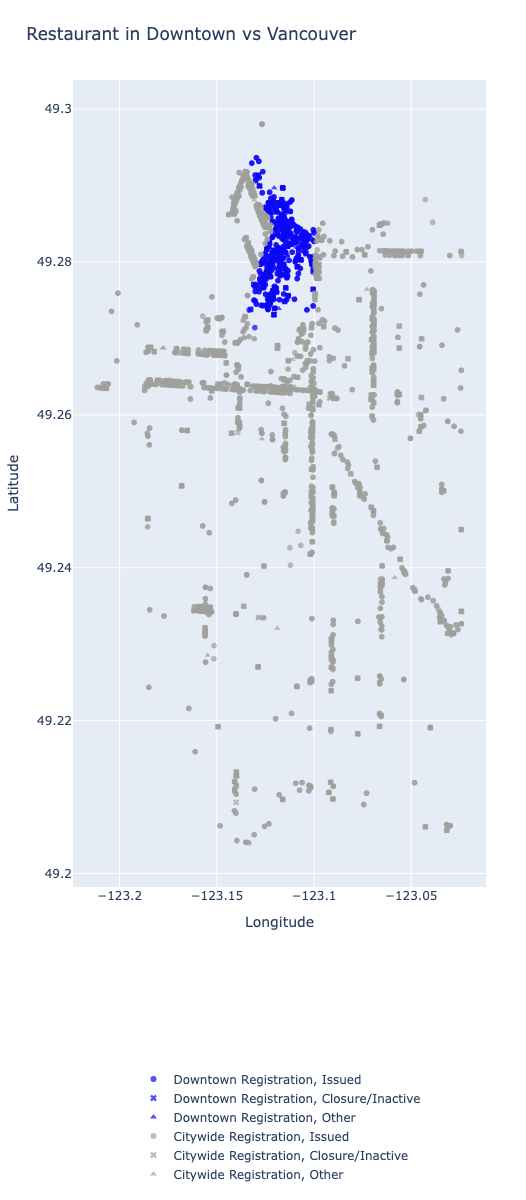

In [29]:
# We can use seaborn like we did earlier, but using Plotly can add an interactive element to our visualization:


import plotly.express as px

def plot_map(business_type, local_area):

    # We'll start with using a lighter dataset:

    df_plot = df_filtered[['BusinessType', 'LocalArea', 'Status', 'lat', 'long']].copy()

    df_plot = df_plot[df_plot['BusinessType'] == business_type].copy()

    # Let's now group our statuses:

    df_plot['Status Group'] = np.where(df_plot['Status'] == 'Issued',
                                       'Issued',
                                       np.where(
                                           df_plot['Status'].isin(['Gone Out of Business', 'Inactive']),
                                           'Closure/Inactive',
                                           'Other'
                                       )
                                      )

    

    # Let's now create highlight labels to drive color:
    
    df_plot['Group'] = 'Background'

    is_type = df_plot["BusinessType"] == business_type
    is_type_and_area = is_type & (df_plot["LocalArea"] == local_area)

    df_plot.loc[is_type, "Group"] = "Citywide Registration"
    df_plot.loc[is_type_and_area, "Group"] = f"{local_area} Registration"

    # Now let's plot:

    fig = px.scatter(
        df_plot,
        x = "long",
        y = "lat",
        color = "Group",
        symbol = "Status Group",
        opacity = 0.7,
        hover_data = ["BusinessType", "LocalArea"],
        title = f"{business_type} in {local_area} vs Vancouver",
        color_discrete_map = {
            'Background': '#d9d9d9',
            'Citywide Registration': '#9f9f9c',
            f'{local_area} Registration': '#0C06F7' # Distinct colors
        },
        symbol_map = {
            'Issued': 'circle',
            'Exit': 'x',
            'Other': 'triangle-up' # Distinct shapes
    }
            
    )

    


    # Let's make our plot as large as we can, and as readable:

    fig.update_layout(
        height = 1200,
        width = 1500,
        xaxis_title = "Longitude",
        yaxis_title = "Latitude",
        legend = dict(
            orientation = "h",
            yanchor = "top",
            y = -0.22,
            xanchor = "center",
            x = 0.5,
            title_text = "" # remove default combined title
        ),
        margin = dict(l = 40, r = 40, t = 80, b = 100)
    )
            
                      
        

    return fig

# Let's test it:


fig = plot_map("Restaurant", "Downtown")
fig.show()

Looking good. Now we want to ship this onto a useable and interpetable system, so we'll carry all the needed functions over into a .py file, that we will use a backend. See logic.py to see the importation.

In [30]:
import logic
logic.load_and_prepare("business-licences.csv")
print(logic.market_interpretation("Restaurant", "Sunset"))
logic.plot_map("Restaurant", "Downtown").show()

IndentationError: unexpected indent (logic.py, line 304)